# Method 9 - Best Ideas Low Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] < popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

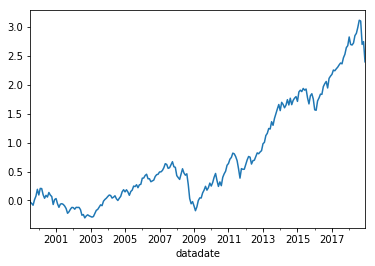

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.191900
2000-12-31   -0.148037
2001-12-31   -0.133557
2002-12-31   -0.165534
2003-12-31    0.414417
2004-12-31    0.141256
2005-12-31    0.079051
2006-12-31    0.135806
2007-12-31    0.082808
2008-12-31   -0.377272
2009-12-31    0.326792
2010-12-31    0.237460
2011-12-31   -0.042684
2012-12-31    0.208284
2013-12-31    0.428877
2014-12-31    0.051449
2015-12-31   -0.014605
2016-12-31    0.143429
2017-12-31    0.167185
2018-12-31   -0.076185
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     854.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.52e-136
Time:                        20:31:16   Log-Likelihood:                 697.04
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.347      0.729      -0.001       0.002
mktrf          1.0528      0.023     45.381      0.000       1.007       1.099
me             0.3579      0.027     13.262      0.000       0.305       0.411
ia            -0.0296      0.041     -0.723      0.471      -0.110       0.051
roe            0.1712      0.035      4.875      0.000       0.102       0.240
==============================================================================
Omnibus:                       28.531   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.566
Skew:                           0.276   Prob(JB):                     1.21e-28
Kurtosis:                       6.589   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     742.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.41e-130
Time:                        20:31:16   Log-Likelihood:                 697.04
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.430      0.667      -0.001       0.002
mktrf          1.0528      0.035     29.885      0.000       0.984       1.122
me             0.3579      0.028     12.647      0.000       0.302       0.413
ia            -0.0296      0.053     -0.557      0.577      -0.134       0.075
roe            0.1712      0.048      3.579      0.000       0.077       0.265
==============================================================================
Omnibus:                       28.531   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.566
Skew:                           0.276   Prob(JB):                     1.21e-28
Kurtosis:                       6.589   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     838.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.92e-135
Time:                        20:31:16   Log-Likelihood:                 697.04
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.465      0.642      -0.001       0.002
mktrf          1.0528      0.037     28.425      0.000       0.980       1.125
me             0.3579      0.030     11.755      0.000       0.298       0.418
ia            -0.0296      0.050     -0.590      0.555      -0.128       0.069
roe            0.1712      0.049      3.522      0.000       0.076       0.266
==============================================================================
Omnibus:                       28.531   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.566
Skew:                           0.276   Prob(JB):                     1.21e-28
Kurtosis:                       6.589   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     571.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.87e-127
Time:                        20:31:16   Log-Likelihood:                 677.99
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     228   BIC:                            -1323.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.685      0.494      -0.001       0.002
mktrf          1.0250      0.025     40.557      0.000       0.975       1.075
smb            0.3760      0.033     11.275      0.000       0.310       0.442
hml           -0.0428      0.039     -1.087      0.278      -0.120       0.035
rmw            0.0986      0.044      2.217      0.028       0.011       0.186
cma            0.0154      0.057      0.273      0.785      -0.096       0.127
==============================================================================
Omnibus:                       51.847   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.444
Skew:                           0.695   Prob(JB):                     1.15e-64
Kurtosis:                       8.316   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     467.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.31e-117
Time:                        20:31:16   Log-Likelihood:                 677.99
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     228   BIC:                            -1323.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.839      0.401      -0.001       0.002
mktrf          1.0250      0.035     29.643      0.000       0.957       1.093
smb            0.3760      0.051      7.442      0.000       0.277       0.475
hml           -0.0428      0.062     -0.687      0.492      -0.165       0.079
rmw            0.0986      0.068      1.447      0.148      -0.035       0.232
cma            0.0154      0.105      0.147      0.883      -0.189       0.220
==============================================================================
Omnibus:                       51.847   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.444
Skew:                           0.695   Prob(JB):                     1.15e-64
Kurtosis:                       8.316   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     412.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.32e-112
Time:                        20:31:16   Log-Likelihood:                 677.99
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     228   BIC:                            -1323.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.947      0.344      -0.001       0.002
mktrf          1.0250      0.037     27.491      0.000       0.952       1.098
smb            0.3760      0.055      6.841      0.000       0.268       0.484
hml           -0.0428      0.064     -0.669      0.503      -0.168       0.082
rmw            0.0986      0.070      1.414      0.157      -0.038       0.235
cma            0.0154      0.102      0.152      0.879      -0.184       0.214
==============================================================================
Omnibus:                       51.847   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.444
Skew:                           0.695   Prob(JB):                     1.15e-64
Kurtosis:                       8.316   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     840.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.42e-135
Time:                        20:31:16   Log-Likelihood:                 695.27
No. Observations:                 234   AIC:                            -1381.
Df Residuals:                     229   BIC:                            -1363.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.579      0.563      -0.001       0.002
mktrf          1.0638      0.022     49.429      0.000       1.021       1.106
smb            0.2747      0.027     10.226      0.000       0.222       0.328
hml            0.0916      0.027      3.431      0.001       0.039       0.144
umd            0.1265      0.018      7.224      0.000       0.092       0.161
==============================================================================
Omnibus:                       34.807   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.602
Skew:                           0.346   Prob(JB):                     4.09e-42
Kurtosis:                       7.367   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     777.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.96e-132
Time:                        20:31:16   Log-Likelihood:                 695.27
No. Observations:                 234   AIC:                            -1381.
Df Residuals:                     229   BIC:                            -1363.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.650      0.516      -0.001       0.002
mktrf          1.0638      0.032     32.937      0.000       1.000       1.127
smb            0.2747      0.050      5.546      0.000       0.178       0.372
hml            0.0916      0.039      2.339      0.019       0.015       0.168
umd            0.1265      0.033      3.871      0.000       0.062       0.191
==============================================================================
Omnibus:                       34.807   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.602
Skew:                           0.346   Prob(JB):                     4.09e-42
Kurtosis:                       7.367   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     962.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.63e-142
Time:                        20:31:16   Log-Likelihood:                 695.27
No. Observations:                 234   AIC:                            -1381.
Df Residuals:                     229   BIC:                            -1363.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.681      0.496      -0.001       0.002
mktrf          1.0638      0.032     32.879      0.000       1.000       1.127
smb            0.2747      0.057      4.850      0.000       0.164       0.386
hml            0.0916      0.037      2.469      0.014       0.019       0.164
umd            0.1265      0.029      4.289      0.000       0.069       0.184
==============================================================================
Omnibus:                       34.807   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.602
Skew:                           0.346   Prob(JB):                     4.09e-42
Kurtosis:                       7.367   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     370.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.12e-64
Time:                        20:31:16   Log-Likelihood:                 336.52
No. Observations:                 120   AIC:                            -663.0
Df Residuals:                     115   BIC:                            -649.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.099      0.921      -0.003       0.003
mktrf          1.1126      0.039     28.843      0.000       1.036       1.189
me             0.3661      0.038      9.610      0.000       0.291       0.442
ia            -0.0773      0.060     -1.295      0.198      -0.195       0.041
roe            0.2805      0.053      5.312      0.000       0.176       0.385
==============================================================================
Omnibus:                        9.351   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               17.599
Skew:                           0.240   Prob(JB):                     0.000151
Kurtosis:                       4.814   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     377.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.85e-65
Time:                        20:31:16   Log-Likelihood:                 336.52
No. Observations:                 120   AIC:                            -663.0
Df Residuals:                     115   BIC:                            -649.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.127      0.899      -0.002       0.002
mktrf          1.1126      0.054     20.781      0.000       1.008       1.218
me             0.3661      0.030     12.226      0.000       0.307       0.425
ia            -0.0773      0.069     -1.127      0.260      -0.212       0.057
roe            0.2805      0.057      4.945      0.000       0.169       0.392
==============================================================================
Omnibus:                        9.351   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               17.599
Skew:                           0.240   Prob(JB):                     0.000151
Kurtosis:                       4.814   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     449.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.30e-69
Time:                        20:31:16   Log-Likelihood:                 336.52
No. Observations:                 120   AIC:                            -663.0
Df Residuals:                     115   BIC:                            -649.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.136      0.892      -0.002       0.002
mktrf          1.1126      0.049     22.928      0.000       1.017       1.208
me             0.3661      0.030     12.008      0.000       0.306       0.426
ia            -0.0773      0.063     -1.223      0.221      -0.201       0.047
roe            0.2805      0.043      6.565      0.000       0.197       0.364
==============================================================================
Omnibus:                        9.351   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               17.599
Skew:                           0.240   Prob(JB):                     0.000151
Kurtosis:                       4.814   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     217.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.60e-56
Time:                        20:31:16   Log-Likelihood:                 319.90
No. Observations:                 120   AIC:                            -627.8
Df Residuals:                     114   BIC:                            -611.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.657      0.513      -0.002       0.004
mktrf          1.0773      0.047     22.959      0.000       0.984       1.170
smb            0.3937      0.053      7.409      0.000       0.288       0.499
hml           -0.1173      0.065     -1.802      0.074      -0.246       0.012
rmw            0.2028      0.077      2.641      0.009       0.051       0.355
cma            0.0424      0.084      0.504      0.615      -0.124       0.209
==============================================================================
Omnibus:                       20.973   Durbin-Watson:                   2.257
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.862
Skew:                           0.634   Prob(JB):                     9.03e-12
Kurtosis:                       5.926   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     241.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.10e-59
Time:                        20:31:16   Log-Likelihood:                 319.90
No. Observations:                 120   AIC:                            -627.8
Df Residuals:                     114   BIC:                            -611.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.937      0.349      -0.001       0.003
mktrf          1.0773      0.059     18.357      0.000       0.962       1.192
smb            0.3937      0.073      5.414      0.000       0.251       0.536
hml           -0.1173      0.090     -1.297      0.195      -0.295       0.060
rmw            0.2028      0.112      1.811      0.070      -0.017       0.422
cma            0.0424      0.137      0.309      0.757      -0.226       0.311
==============================================================================
Omnibus:                       20.973   Durbin-Watson:                   2.257
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.862
Skew:                           0.634   Prob(JB):                     9.03e-12
Kurtosis:                       5.926   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     219.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.49e-57
Time:                        20:31:16   Log-Likelihood:                 319.90
No. Observations:                 120   AIC:                            -627.8
Df Residuals:                     114   BIC:                            -611.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.019      0.308      -0.001       0.003
mktrf          1.0773      0.062     17.482      0.000       0.956       1.198
smb            0.3937      0.077      5.110      0.000       0.243       0.545
hml           -0.1173      0.099     -1.187      0.235      -0.311       0.076
rmw            0.2028      0.119      1.699      0.089      -0.031       0.437
cma            0.0424      0.137      0.310      0.756      -0.226       0.310
==============================================================================
Omnibus:                       20.973   Durbin-Watson:                   2.257
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.862
Skew:                           0.634   Prob(JB):                     9.03e-12
Kurtosis:                       5.926   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     337.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-62
Time:                        20:31:16   Log-Likelihood:                 331.42
No. Observations:                 120   AIC:                            -652.8
Df Residuals:                     115   BIC:                            -638.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.403      0.163      -0.001       0.005
mktrf          1.1101      0.035     31.307      0.000       1.040       1.180
smb            0.2223      0.040      5.506      0.000       0.142       0.302
hml            0.0777      0.040      1.922      0.057      -0.002       0.158
umd            0.1547      0.025      6.206      0.000       0.105       0.204
==============================================================================
Omnibus:                        9.958   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               23.235
Skew:                           0.110   Prob(JB):                     9.01e-06
Kurtosis:                       5.144   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     359.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.14e-64
Time:                        20:31:16   Log-Likelihood:                 331.42
No. Observations:                 120   AIC:                            -652.8
Df Residuals:                     115   BIC:                            -638.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.785      0.074      -0.000       0.004
mktrf          1.1101      0.044     25.429      0.000       1.025       1.196
smb            0.2223      0.053      4.207      0.000       0.119       0.326
hml            0.0777      0.051      1.534      0.125      -0.022       0.177
umd            0.1547      0.040      3.874      0.000       0.076       0.233
==============================================================================
Omnibus:                        9.958   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               23.235
Skew:                           0.110   Prob(JB):                     9.01e-06
Kurtosis:                       5.144   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     476.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-70
Time:                        20:31:16   Log-Likelihood:                 331.42
No. Observations:                 120   AIC:                            -652.8
Df Residuals:                     115   BIC:                            -638.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.856      0.063      -0.000       0.004
mktrf          1.1101      0.037     30.168      0.000       1.038       1.182
smb            0.2223      0.057      3.886      0.000       0.110       0.334
hml            0.0777      0.049      1.597      0.110      -0.018       0.173
umd            0.1547      0.032      4.776      0.000       0.091       0.218
==============================================================================
Omnibus:                        9.958   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               23.235
Skew:                           0.110   Prob(JB):                     9.01e-06
Kurtosis:                       5.144   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     799.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.20e-80
Time:                        20:31:16   Log-Likelihood:                 394.01
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     109   BIC:                            -764.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.473      0.144      -0.000       0.003
mktrf          0.9870      0.023     43.003      0.000       0.942       1.032
me             0.3661      0.035     10.331      0.000       0.296       0.436
ia             0.0256      0.049      0.521      0.604      -0.072       0.123
roe           -0.0479      0.043     -1.108      0.270      -0.133       0.038
==============================================================================
Omnibus:                        0.645   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.747
Skew:                          -0.056   Prob(JB):                        0.688
Kurtosis:                       2.619   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1023.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-85
Time:                        20:31:16   Log-Likelihood:                 394.01
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     109   BIC:                            -764.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.625      0.104      -0.000       0.003
mktrf          0.9870      0.019     50.718      0.000       0.949       1.025
me             0.3661      0.041      8.886      0.000       0.285       0.447
ia             0.0256      0.047      0.544      0.586      -0.067       0.118
roe           -0.0479      0.044     -1.077      0.282      -0.135       0.039
==============================================================================
Omnibus:                        0.645   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.747
Skew:                          -0.056   Prob(JB):                        0.688
Kurtosis:                       2.619   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1019.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.42e-85
Time:                        20:31:16   Log-Likelihood:                 394.01
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     109   BIC:                            -764.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      2.051      0.040    5.08e-05       0.002
mktrf          0.9870      0.020     48.748      0.000       0.947       1.027
me             0.3661      0.047      7.808      0.000       0.274       0.458
ia             0.0256      0.050      0.508      0.611      -0.073       0.124
roe           -0.0479      0.036     -1.326      0.185      -0.119       0.023
==============================================================================
Omnibus:                        0.645   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.747
Skew:                          -0.056   Prob(JB):                        0.688
Kurtosis:                       2.619   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     705.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-80
Time:                        20:31:16   Log-Likelihood:                 399.95
No. Observations:                 114   AIC:                            -787.9
Df Residuals:                     108   BIC:                            -771.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.333      0.740      -0.001       0.002
mktrf          0.9923      0.021     47.538      0.000       0.951       1.034
smb            0.3599      0.034     10.622      0.000       0.293       0.427
hml           -0.0230      0.043     -0.533      0.595      -0.109       0.063
rmw           -0.0835      0.053     -1.579      0.117      -0.188       0.021
cma            0.0340      0.067      0.506      0.614      -0.099       0.167
==============================================================================
Omnibus:                        3.542   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.071
Skew:                          -0.004   Prob(JB):                        0.355
Kurtosis:                       2.340   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     484.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.27e-72
Time:                        20:31:16   Log-Likelihood:                 399.95
No. Observations:                 114   AIC:                            -787.9
Df Residuals:                     108   BIC:                            -771.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.321      0.748      -0.001       0.002
mktrf          0.9923      0.024     41.494      0.000       0.945       1.039
smb            0.3599      0.046      7.784      0.000       0.269       0.451
hml           -0.0230      0.043     -0.530      0.596      -0.108       0.062
rmw           -0.0835      0.055     -1.509      0.131      -0.192       0.025
cma            0.0340      0.047      0.719      0.472      -0.059       0.127
==============================================================================
Omnibus:                        3.542   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.071
Skew:                          -0.004   Prob(JB):                        0.355
Kurtosis:                       2.340   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     473.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-71
Time:                        20:31:16   Log-Likelihood:                 399.95
No. Observations:                 114   AIC:                            -787.9
Df Residuals:                     108   BIC:                            -771.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.402      0.688      -0.001       0.001
mktrf          0.9923      0.027     36.772      0.000       0.939       1.045
smb            0.3599      0.053      6.825      0.000       0.257       0.463
hml           -0.0230      0.037     -0.630      0.528      -0.095       0.049
rmw           -0.0835      0.053     -1.575      0.115      -0.188       0.020
cma            0.0340      0.038      0.895      0.371      -0.040       0.109
==============================================================================
Omnibus:                        3.542   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.071
Skew:                          -0.004   Prob(JB):                        0.355
Kurtosis:                       2.340   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     919.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.80e-83
Time:                        20:31:16   Log-Likelihood:                 401.72
No. Observations:                 114   AIC:                            -793.4
Df Residuals:                     109   BIC:                            -779.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.187      0.852      -0.002       0.001
mktrf          1.0070      0.020     49.539      0.000       0.967       1.047
smb            0.3759      0.032     11.858      0.000       0.313       0.439
hml            0.0688      0.033      2.108      0.037       0.004       0.134
umd            0.0572      0.025      2.325      0.022       0.008       0.106
==============================================================================
Omnibus:                        3.381   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                2.015
Skew:                          -0.010   Prob(JB):                        0.365
Kurtosis:                       2.349   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     551.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.45e-71
Time:                        20:31:16   Log-Likelihood:                 401.72
No. Observations:                 114   AIC:                            -793.4
Df Residuals:                     109   BIC:                            -779.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.166      0.868      -0.002       0.001
mktrf          1.0070      0.024     42.620      0.000       0.961       1.053
smb            0.3759      0.034     11.097      0.000       0.309       0.442
hml            0.0688      0.038      1.806      0.071      -0.006       0.143
umd            0.0572      0.019      2.957      0.003       0.019       0.095
==============================================================================
Omnibus:                        3.381   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                2.015
Skew:                          -0.010   Prob(JB):                        0.365
Kurtosis:                       2.349   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     405.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.78e-64
Time:                        20:31:16   Log-Likelihood:                 401.72
No. Observations:                 114   AIC:                            -793.4
Df Residuals:                     109   BIC:                            -779.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.204      0.838      -0.001       0.001
mktrf          1.0070      0.027     37.269      0.000       0.954       1.060
smb            0.3759      0.037     10.181      0.000       0.303       0.448
hml            0.0688      0.037      1.862      0.063      -0.004       0.141
umd            0.0572      0.018      3.239      0.001       0.023       0.092
==============================================================================
Omnibus:                        3.381   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                2.015
Skew:                          -0.010   Prob(JB):                        0.365
Kurtosis:                       2.349   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""